File written to NiftyFile.csv
File written to Volatility_12042019
data gathering complete
select the company to be analyzed    
1     ==>   Vodafone Idea Ltd.
2     ==>   Tata Motors Ltd.
3     ==>   DLF Ltd.
4     ==>   Indiabulls Housing Finance Ltd.
5     ==>   Yes Bank Ltd.
6     ==>   Zee Entertainment Enterprises Ltd.
7     ==>   Tata Motors Ltd DVR
8     ==>   Hindustan Petroleum Corporation Ltd.
9     ==>   Steel Authority of India Ltd.
10     ==>   Vedanta Ltd.
11     ==>   Motherson Sumi Systems Ltd.
12     ==>   ICICI Prudential Life Insurance Company Ltd.
13     ==>   InterGlobe Aviation Ltd.
14     ==>   Bajaj Holdings & Investment Ltd.
15     ==>   Indian Oil Corporation Ltd.
16     ==>   Bharti Airtel Ltd.
17     ==>   Bharat Petroleum Corporation Ltd.
18     ==>   Ashok Leyland Ltd.
19     ==>   General Insurance Corporation of India
20     ==>   Bank of Baroda
21     ==>   Bharat Heavy Electricals Ltd.
22     ==>   The New India Assurance Company Ltd.
23     ==>   Page

<Figure size 7200x3600 with 0 Axes>

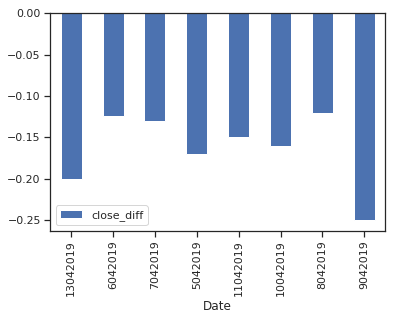

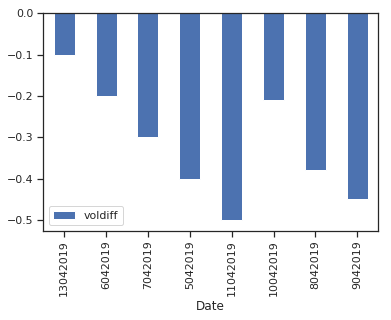

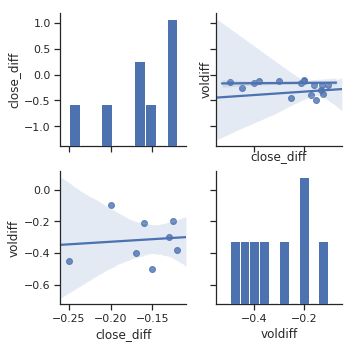

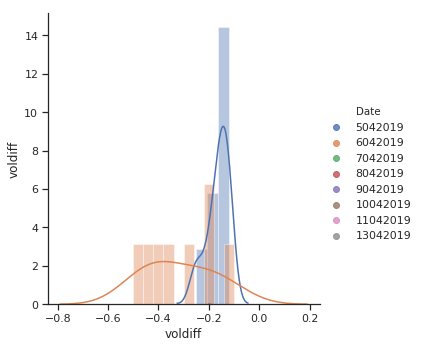

In [386]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import sys
import time
import requests
from datetime import datetime, timedelta

##########################################################################################
timestr = time.strftime("%Y%m%d")
mydate=time.strftime("%d%m%Y")
s = mydate
date = datetime.strptime(s, "%d%m%Y")
if datetime.now().strftime('%A')=='Saturday':
    modified_date = date + timedelta(days=-1)
elif datetime.now().strftime('%A')=='Sunday': 
    modified_date = date + timedelta(days=-2)
else:
    modified_date=datetime.now()
correct_date=datetime.strftime(modified_date, "%d%m%Y")

def data_Downloader(url,filename):
    data=requests.get(url)
    if data.status_code==200:
        datacsv=data.text
    
        with open(filename,'w') as handler:
            handler.write(datacsv)
        print('File written to '+ filename)
        return 'success'
    else:
        return 'failed'

niftyfileUrl='https://www.nseindia.com/content/indices/ind_nifty100list.csv'

NiftyFile='NiftyFile.csv'
niftyout=data_Downloader(niftyfileUrl,NiftyFile)

volatility='https://www.nseindia.com/archives/nsccl/volt/CMVOLT_'+ correct_date +'.CSV'

volatilityFile='Volatility_'+correct_date

volout=data_Downloader(volatility,volatilityFile)

if niftyout=='success' and volout=='success':
    print( 'data gathering complete')
else:
    print('can not gather data , exiting ')
    sys.exit()
#reading both files
df1 = pd.read_csv(NiftyFile, header=0 )
df2 = pd.read_csv(volatilityFile, header=0)
#merging both files
df = pd.merge(df1, df2, on='Symbol')
df = df.sort_values(by=['Underlying Annualised Volatility (F) = E*Sqrt(365)', 'Previous Day Underlying Volatility (D)','Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)'])
df.loc[:,'Previous Day Underlying Volatility (D)'] *= 100
df.loc[:,'Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)'] *= 100
df.loc[:,'Underlying Annualised Volatility (F) = E*Sqrt(365)'] *= 100
df=df.loc[df['Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)'] >= 2]
df = df.sort_values('Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)',ascending=[False])
df.rename(columns={'Previous Day Underlying Volatility (D)': 'previous_volatality', 'Current Day Underlying Daily Volatility (E) = Sqrt(0.94*D*D + 0.06*C*C)': 'current_volatality','Underlying Annualised Volatility (F) = E*Sqrt(365)':'annual volatality','Underlying Previous Day Close Price (B)':'previous close','Underlying Close Price (A)':'current close','Company Name':'company_name'}, inplace=True)
df['Date']=s
df1=df[['company_name','Date','current close','previous close','previous_volatality','current_volatality']]
df1['close_diff']=df1['current close']-df1['previous close']
df1['voldiff']=df1['current_volatality']-df1['previous_volatality']
completedf=df1.drop(['current close','previous close','previous_volatality','current_volatality'],axis=1)
#saving the data in a file 
mainfile='completeData.csv'
def check_availability(element, collection: iter):
    return True
if os.path.isfile(mainfile) and os.stat(mainfile).st_size != 0:
    with open(mainfile,'a') as handler:
        if not check_availability(int(completedf.Date.unique()[0]),list(pd.read_csv(mainfile).Date.unique())):
            completedf.to_csv(handler,sep=',',index=False,header=None)
elif os.path.isfile(mainfile) and os.stat(mainfile).st_size == 0:
    with open(mainfile,'a') as handler:
         completedf.to_csv(handler,sep=',',index=False)
elif not os.path.isfile(mainfile):
    with open(mainfile,'a') as handler:
         completedf.to_csv(handler,sep=',',index=False)
else:
        print('data already exist')
#reading the main file now for analysis
maindataFrameAnalysis=pd.read_csv(mainfile,header=0)
company_names=maindataFrameAnalysis.company_name.unique()
company_names=list(company_names)
print('select the company to be analyzed    ')
for index,values in enumerate(list(company_names)):
    print (str(index+1 )+  '     ==>   '  +values)
company=int(input().strip())-1
company_selected=company_names[company]
companydf=maindataFrameAnalysis.loc[maindataFrameAnalysis['company_name']==company_selected]
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(100, 50))
sns.set(style="ticks", color_codes=True)
companydf.plot(x='Date',y='close_diff',kind='bar')
companydf.plot(x='Date',y='voldiff',kind='bar')
#linear regression plot
#removing date column
#showing the relation between volatility difference and the closing difference from previous date.
#this is a linear regresssion plot to show the stock market value for a company real time data gathering


nondatecompanydf=companydf.drop(['Date'],axis=1)
g = sns.pairplot(nondatecompanydf, kind="reg")
sns.regplot(companydf.close_diff,companydf.voldiff)
sns.lmplot(x='close_diff',y='voldiff',data=companydf, hue="Date")
sns.distplot(companydf.close_diff)
sns.distplot(companydf.voldiff,bins=10)